In [182]:
import tcsim.system
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
### find orthogonality 


### Functions

# System
N = 50

Iq = qeye(2)
Ic = qeye(N)
a = destroy(N)
sx = sigmax()
sz = sigmaz()
Q = (a + a.dag())/2
P = 1j*(a-a.dag())/2



t1 = 100
gamma_a_loss = 1 / t1  # t1 = 100mu s
a_loss = np.sqrt(gamma_a_loss) * destroy(N)

### Functions

# calculate time evolution of a given state
def lossy_channel(state, wait_time):
    t_list = np.linspace(0, wait_time, 100)
    rho_loss = mesolve(Ic,state, t_list, c_ops = a_loss).states[-1]
    return rho_loss

# find the min value of the wigner function, assuming the blobs are align on the X axis
def wigner_negativiy(state):
    yvec = np.linspace(-2,2,101) # guarantees that yvec has 0.0
    W = wigner(state,0, yvec, g = 2)
    return np.min(W[:,0])*np.pi/2 # normalize to 1

# send the states through the channel, find their respective wigner and store the results in a nested list negativity_loss[0] -> result for states[0]
def get_data(states, ts):
    negativity_loss=[]
    for i in range(len(states)):
        negativity_loss.append([])
    
    for t in ts:
        for i in range(len(states)):
            rho_loss = lossy_channel(states[i],t)
            negativity = wigner_negativiy(rho_loss)
            negativity_loss[i].append(negativity)
            
    return negativity_loss

# used to turn t1 into the evolution time into a transmission value
def transmission (t):
    return np.exp(-t/t1)

def relative_to_t1(t):
    return t/t1

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

# getting the squeezed cat states with matched overlap
def overlap_squeezed(beta, alpha, squeezing_parameter_db):
    squeezing_parameter = calc_squeez_parameter(squeezing_parameter_db)
    coherent_overlap = coherent(N,alpha).overlap(coherent(N,-alpha))
    squeezed_overlap = (displace(N,beta[0])*squeeze(N,squeezing_parameter)*coherent(N,0)).overlap((displace(N,-beta[0])*squeeze(N,squeezing_parameter)*coherent(N,0)))
    return np.abs(coherent_overlap-squeezed_overlap)

def find_beta_squeezed(beta0, alpha, dB):
    result = optimize.minimize(overlap_squeezed, beta0,  args=(alpha, dB),  method= 'Powell', options={'gtol': 1e-8, 'disp': True})
    fitted_params = result.x
    return fitted_params

def state_creation_same_overlap(alpha, squeezing_array_db):
    states = []
    print(alpha)
    cat = (coherent(N,alpha) -coherent(N,-alpha)).unit()
    states.append(cat)
    for db in squeezing_array_db:
        beta = find_beta_squeezed(alpha, alpha, db)[0]
        squeezed_cat = ((displace(N,beta)-displace(N,-beta))*squeeze(N,calc_squeez_parameter(db))*coherent(N,0)).unit()
        states.append(squeezed_cat)
    return states

In [190]:
alpha = 0.5
dBs = [0,2,4,6,8,10]

states = state_creation_same_overlap(alpha,dBs)

0.5


C:\Users\jonat\AppData\Local\Temp\ipykernel_27032\2371438753.py:74: OptimizeWarning: Unknown solver options: gtol
  result = optimize.minimize(overlap_squeezed, beta0,  args=(alpha, dB),  method= 'Powell', options={'gtol': 1e-8, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 196


In [199]:
ts = np.linspace(0.1,80, 9) # values are chosen such that we are between transmission of 0.5 (70) and 1 (0.1)
negativity_loss = get_data(states, ts)

transmis = []
for i in ts:
    transmis.append(transmission(i))
    
rel_t1 = []
for i in ts:
    rel_t1.append(relative_to_t1(i))


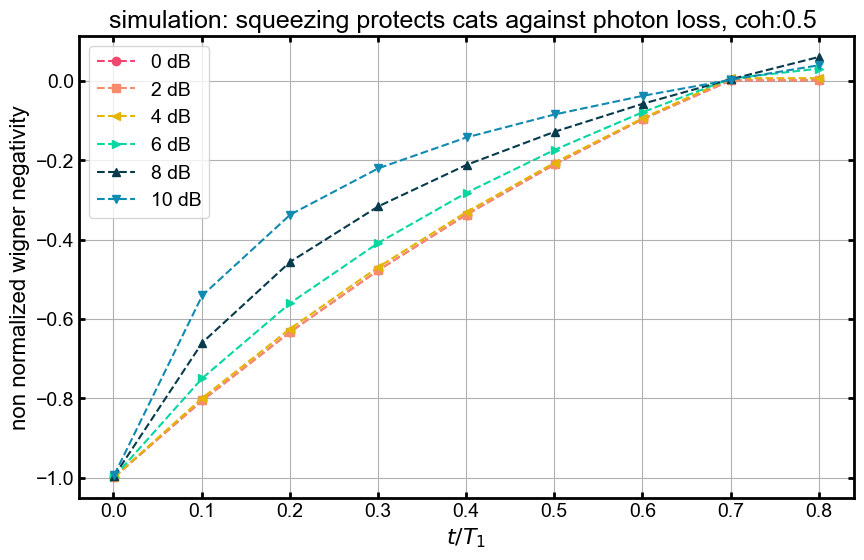

In [202]:
import matplotlib as mpl
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams["axes.linewidth"] = 2.0
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.sans-serif'] ='Arial'
mpl.rcParams['axes.labelsize']= 8
mpl.rcParams['legend.fontsize'] = 14

fig, ax = plt.subplots(figsize = (10,6))

ax.tick_params(direction = "in", bottom=True, top=True, left=True, right=True, length=4, width=2, labelsize = 14)
ax.grid();

#general_figure()plt.plot(transmis,negativity_loss[0], 'o', label = '0')
ax.plot(rel_t1,negativity_loss[0], '--o', color = '#ef476f', label = '0 dB')
ax.plot(rel_t1,negativity_loss[1], '--s', color = '#f78c6b',label = '2 dB')
ax.plot(rel_t1,negativity_loss[2], '--<', color = '#E3B505',label = '4 dB')
ax.plot(rel_t1,negativity_loss[3], '-->', color = '#06d6a0',label = '6 dB')
ax.plot(rel_t1,negativity_loss[4], '--^', color = '#073b4c',label = '8 dB')
ax.plot(rel_t1,negativity_loss[5], '--v', color = '#118ab2',label = '10 dB')

ax.set_xlim()

ax.set_title(f"simulation: squeezing protects cats against photon loss, coh:{alpha} ", fontsize=18)
ax.set_xlabel(r"$t/T_1$", fontsize=16)
ax.set_ylabel("non normalized wigner negativity", fontsize=16)

ax.legend()


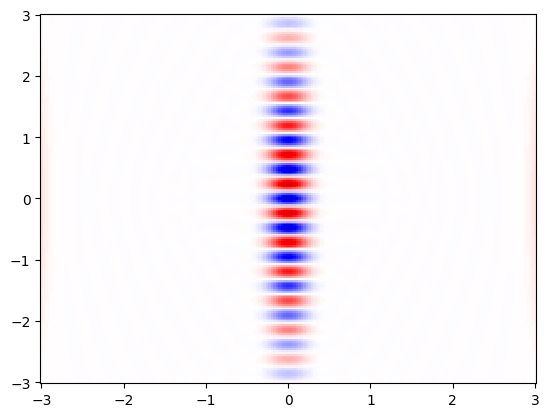

In [163]:
fig, ax = plt.subplots()

xvec = np.linspace(-3,3,200)
yvec = np.linspace(-3,3,200)
X, Y = np.meshgrid(xvec, yvec)
W = wigner(states[6],xvec, yvec, g = 2)


ax.pcolormesh(xvec,yvec,W,linewidth=0, rasterized=True,cmap = "seismic",shading='auto', vmin = -1, vmax = 1)
#cset = ax.contour(X, Y, W, 1, zdir='x', offset=-5, cmap="Reds")
#cset = ax.contour(X, Y, W, 1, zdir='y', offset=2.5, cmap="Reds")
# Hide grid lines

plt.show()